In [2]:
!pip install torchsummary

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from tqdm import trange, tqdm
from matplotlib import pyplot as plt
from torchsummary import summary

In [4]:
%matplotlib inline

In [5]:
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available():  
  DEVICE = "cuda:0" 
else:  
  DEVICE = "cpu" 

Tesla P100-PCIE-16GB


## ResNet
Downloaded from https://github.com/FrancescoSaverioZuppichini/ResNet/blob/master/ResNet.ipynb

In [6]:
from collections import OrderedDict
from functools import partial


class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)      
        

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))
    
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x


class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x


class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

In [7]:
model = resnet34(3, 1000).to(DEVICE)
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
        Conv2dAuto-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
        Conv2dAuto-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
 ResNetBasicBlock-10           [-1, 64, 16, 16]               0
       Conv2dAuto-11           [-1, 64, 16, 16]          36,864
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
       Conv2dAuto-14           [-1, 64,

## CIFAR10

In [8]:
train_set = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10',
    train = True,
    download = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
)

test_set = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10',
    train = False,
    download = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


In [176]:
train_subset = Subset(train_set, range(20000))
test_small = Subset(train_set, range(5000, 5500))
train_loader = DataLoader(train_subset, batch_size = 32, num_workers=2, shuffle=True)
test_loader = DataLoader(test_set, batch_size=512, num_workers=2, shuffle=False)


## ResNet18 & ResNet34

In [13]:
def test(test_dl, train_dl, model, loss_fn):
    test_size = len(test_dl.dataset)
    test_num_batches = len(test_dl)

    train_size = len(train_dl.dataset)
    train_num_batches = len(train_dl)

    model.eval()
    train_loss, train_correct, test_loss, test_correct = 0, 0, 0, 0

    with torch.no_grad():
        for X, y in test_dl:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        for X,y in train_dl:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            train_loss += loss_fn(pred, y).item()
            train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= test_num_batches
    train_loss /= train_num_batches
    test_correct /= test_size
    train_correct /= train_size

    return {'test_accuracy':test_correct, 'test_loss':test_loss, 
          'train_accuracy':train_correct, 'train_loss': train_loss}

In [ ]:
learning_rates = [0.05, 0.01, 0.005, 0.001, 0.0005]
results18 = []
results34 = []

for learning_rate in tqdm(learning_rates):

    Resnet18 = resnet18(3, 10).to(DEVICE)
    Resnet34 = resnet34(3, 10).to(DEVICE)
    optimizer18 = torch.optim.Adam(Resnet18.parameters(), lr=learning_rate)
    optimizer34 = torch.optim.Adam(Resnet34.parameters(), lr=learning_rate)

    for epoch in range(10):
        for batch in train_loader:
            images = batch[0].to(DEVICE)
            labels = batch[1].to(DEVICE)
            # train 18
            preds = Resnet18(images)
            loss = F.cross_entropy(preds, labels)

            optimizer18.zero_grad()
            loss.backward()
            optimizer18.step()  

            # train 34
            preds = Resnet34(images)
            loss = F.cross_entropy(preds, labels)

            optimizer34.zero_grad()
            loss.backward()
            optimizer34.step()  

        results18 += [test(test_loader, train_loader, Resnet18, F.cross_entropy)]
        results18[-1]['learning_rate'] = learning_rate
        results34 += [test(test_loader, train_loader, Resnet34, F.cross_entropy)]
        results34[-1]['learning_rate'] = learning_rate
        print(results18)

In [31]:
results18_df = pd.DataFrame(results18)
results18_df['epoch'] = [i for i in range(1, 11)] * 5
results34_df = pd.DataFrame(results34)
results34_df['epoch'] = [i for i in range(1, 11)] * 5


In [34]:
long_res34 = pd.melt(results34_df, value_vars = ['test_accuracy', 'train_accuracy', 'train_loss', 'test_loss'], id_vars=['epoch', 'learning_rate'])
long_res34['dataset'] = long_res34.apply(lambda x : 'test' if x['variable'].startswith('test') else 'train', axis=1)
long_res34['metric'] = long_res34.apply(lambda x : 'accuracy' if x['variable'].endswith('accuracy') else 'loss', axis=1)
long_res34['model'] = 'ResNet34'

In [65]:
long_res18 = pd.melt(results18_df, value_vars = ['test_accuracy', 'train_accuracy', 'train_loss', 'test_loss'], id_vars=['epoch', 'learning_rate'])
long_res18['dataset'] = long_res18.apply(lambda x : 'test' if x['variable'].startswith('test') else 'train', axis=1)
long_res18['metric'] = long_res18.apply(lambda x : 'accuracy' if x['variable'].endswith('accuracy') else 'loss', axis=1)
long_res18['model'] = 'ResNet18'
result = pd.concat([long_res34, long_res18], axis=0, ignore_index=True)

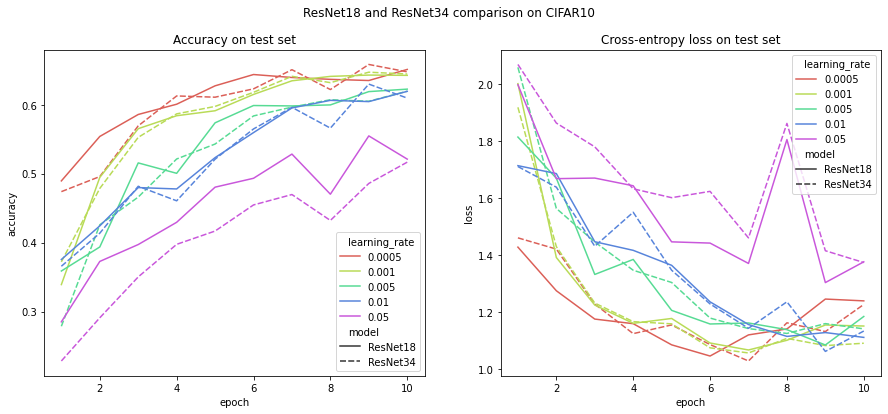

In [130]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('ResNet18 and ResNet34 comparison on CIFAR10')
sns.lineplot(data=result[(result['metric'] == 'accuracy') & (result['dataset'] == 'test')], y='value', x='epoch', hue='learning_rate', style='model', 
             style_order=['ResNet18', 'ResNet34'], palette=sns.hls_palette(5), ax=ax1)
ax1.set_title('Accuracy on test set')
ax1.set_ylabel('accuracy')
sns.lineplot(data=result[(result['metric'] == 'loss') & (result['dataset'] == 'test')], y='value', x='epoch', hue='learning_rate', style='model', 
             style_order=['ResNet18', 'ResNet34'], palette=sns.hls_palette(5), ax=ax2)
ax2.set_title('Cross-entropy loss on test set')
ax2.set_ylabel('loss')
plt.show()

* Best results with small learning rates: 0.0005 and 0.001. 
* ResNet34 and ResNet18 have similar performance.

Now we will examine models with the best learning rate: 0.0005. 

We can see overfitting after 6 epoch. It can be avoided with regularization methods.

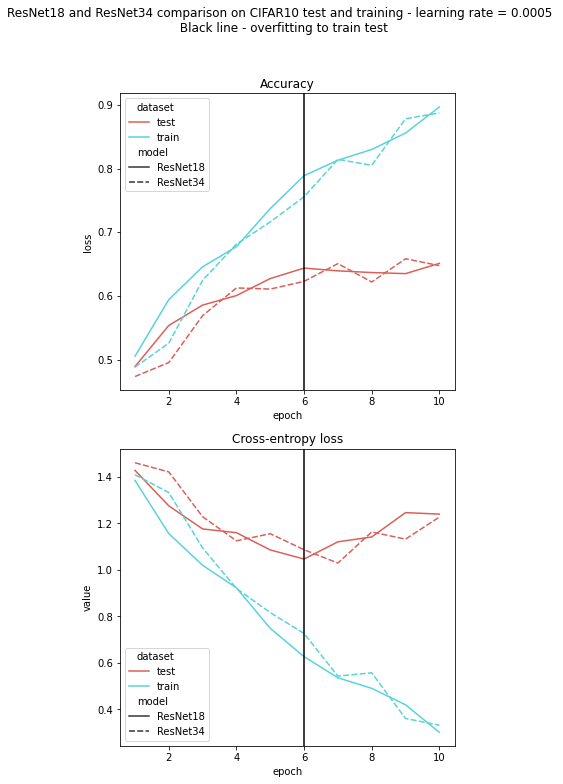

In [128]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6, 12))
fig.suptitle('ResNet18 and ResNet34 comparison on CIFAR10 test and training - learning rate = 0.0005 \n Black line - overfitting to train test')
sns.lineplot(data=result[(result['metric'] == 'accuracy') & (result['learning_rate'] == 0.0005)], y='value', x='epoch', hue='dataset', style='model', 
             style_order=['ResNet18', 'ResNet34'], palette=sns.hls_palette(2), hue_order=['test', 'train'], ax=ax1)
ax1.set_title('Accuracy')
ax1.set_ylabel('accuracy')
ax1.axvline(6, 0,1, c='black')
sns.lineplot(data=result[(result['metric'] == 'loss') & (result['learning_rate'] == 0.0005)], y='value', x='epoch', hue='dataset', style='model', 
             style_order=['ResNet18', 'ResNet34'], palette=sns.hls_palette(2), hue_order=['test', 'train'], ax=ax2)
ax2.set_title('Cross-entropy loss')
ax2.axvline(6, 0,1, c='black')
ax1.set_ylabel('loss')
plt.show()

## ResNet18 with weight decay regularization 

In [85]:
class ResNetDropout(nn.Module):
    
    def __init__(self, in_channels, n_classes, p, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.dropout = nn.Dropout(p)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout(x)
        x = self.decoder(x)
        return x

def resnet18Dropout(in_channels, n_classes, p=0.5):
    return ResNetDropout(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2], p=p)


In [ ]:
model = resnet18Dropout(3, 10).to(DEVICE)
summary(model, (3, 64, 64))

In [182]:
weight_decays = [0.1, 0.01, 0.001]
decay_results = []

for wd in weight_decays:
    Resnet18 = resnet18(3, 10).to(DEVICE)
    optimizer = torch.optim.Adam(Resnet18.parameters(), lr=0.0005, weight_decay=wd)
    for epoch in trange(10):
        Resnet18.train()
        for batch in train_loader:
            images = batch[0].to(DEVICE)
            labels = batch[1].to(DEVICE)
            preds = Resnet18(images)
            loss = F.cross_entropy(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
        decay_results += [test(test_loader, train_loader, Resnet18, F.cross_entropy)]
        decay_results[-1]['decay'] = wd

100%|██████████| 10/10 [03:30<00:00, 21.05s/it]


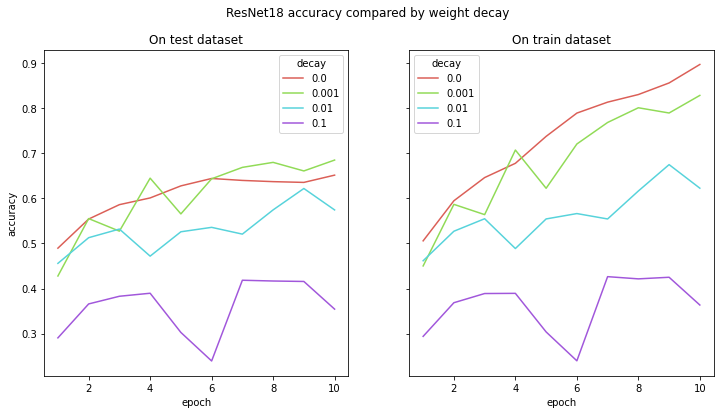

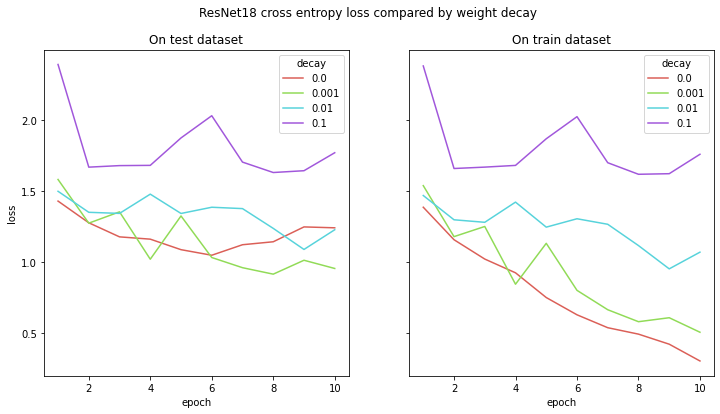

In [189]:
decay_results_df = pd.DataFrame(decay_results)
decay_results_df['epoch'] = [i for i in range(1, 11)] * 3
decay_results_df
long_decay = pd.melt(decay_results_df, value_vars = ['test_accuracy', 'train_accuracy', 'train_loss', 'test_loss'], id_vars=['epoch', 'decay'])
long_decay['dataset'] = long_decay.apply(lambda x : 'test' if x['variable'].startswith('test') else 'train', axis=1)
long_decay['metric'] = long_decay.apply(lambda x : 'accuracy' if x['variable'].endswith('accuracy') else 'loss', axis=1)
long_decay['model'] = 'ResNet18-decay'
long_res18['decay'] = 0
df = pd.concat([long_decay, long_res18[long_res18['learning_rate'] == 0.0005]], axis=0, ignore_index=True)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6), sharey=True)
fig.suptitle('ResNet18 accuracy compared by weight decay')
sns.lineplot(data=df[(df['metric'] == 'accuracy') & (df['dataset'] == 'test')], y='value', x='epoch', hue='decay', palette=sns.hls_palette(4), ax=ax1)
ax1.set_title('On test dataset')
ax1.set_ylabel('accuracy')
sns.lineplot(data=df[(df['metric'] == 'accuracy') & (df['dataset'] == 'train')], y='value', x='epoch', hue='decay', palette=sns.hls_palette(4), ax=ax2)
ax2.set_title('On train dataset')
ax2.set_ylabel('accuracy')
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6), sharey=True)
fig.suptitle('ResNet18 cross entropy loss compared by weight decay')
sns.lineplot(data=df[(df['metric'] == 'loss') & (df['dataset'] == 'test')], y='value', x='epoch', hue='decay', palette=sns.hls_palette(4), ax=ax1)
ax1.set_title('On test dataset')
ax1.set_ylabel('loss')
sns.lineplot(data=df[(df['metric'] == 'loss') & (df['dataset'] == 'train')], y='value', x='epoch', hue='decay', palette=sns.hls_palette(4), ax=ax2)
ax2.set_title('On train dataset')
ax2.set_ylabel('loss')
plt.show()

We can see that adding small weight decay (0.001) can protect from overfitting and improve metrics on test set.

Let's train network with best parameters : weight decay = 0.001 and learning rate = 0.0005. 

In [190]:
Resnet18 = resnet18(3, 10).to(DEVICE)
optimizer = torch.optim.Adam(Resnet18.parameters(), lr=0.0005, weight_decay=0.001)
for epoch in trange(10):
    Resnet18.train()
    for batch in train_loader:
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = Resnet18(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 

100%|██████████| 10/10 [02:10<00:00, 13.01s/it]


In [221]:
test(test_loader, train_loader, Resnet18, F.cross_entropy)

{'test_accuracy': 0.6798,
 'test_loss': 0.9695381134748459,
 'train_accuracy': 0.81475,
 'train_loss': 0.5384800793170929}

## Confusion matrix

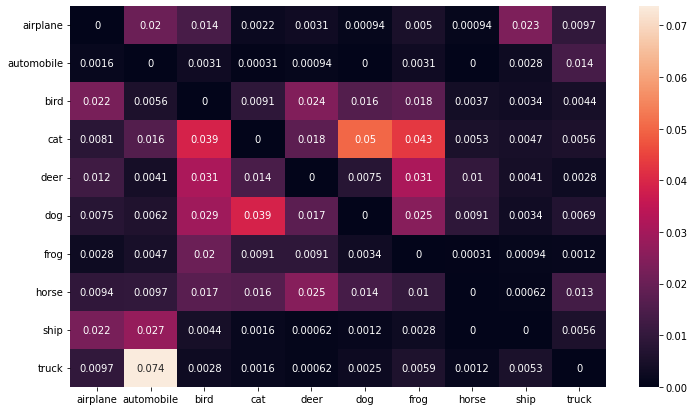

In [209]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []
Resnet18.eval()
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        pred = Resnet18(X)
        output = pred.argmax(1).type(torch.float).cpu()
        y_pred.extend(output) # Save Prediction
        labels = y.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
normalized = cf_matrix - np.diag(np.diag(cf_matrix))
df_cm = pd.DataFrame(normalized / np.sum(normalized), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.show()


In [ ]:
toImage = torchvision.transforms.ToPILImage()
zoom = torchvision.transforms.Resize((256,256))
limit = 50
missclassified = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        pred = Resnet18(X)
        output = pred.argmax(1).type(torch.float).cpu().numpy()
        y_pred.extend(output) 
        labels = y.data.cpu().numpy()
        y_true.extend(labels)
        errors = X[output != labels].cpu()
        e_labels = labels[output != labels]
        e_outputs = output[output != labels]
        for error, label, guess, idx in zip(errors, e_labels, e_outputs, range(512)):
            if limit == 0:
                break
            img = toImage(zoom(error))
            display(img)
            missclassified += [{'img': img, 'label': label, 'guess':int(guess)}]
            print(idx)
            print('actual:', classes[label])
            print('predicted:', classes[int(guess)])
            limit -=1

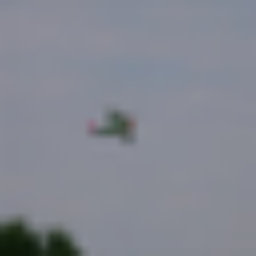

actual: airplane
actual: bird


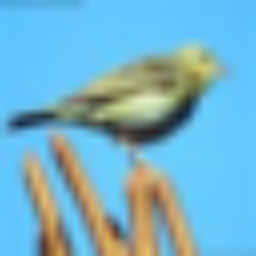

actual: bird
actual: airplane


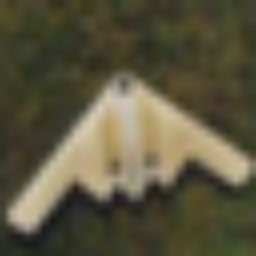

actual: airplane
actual: bird


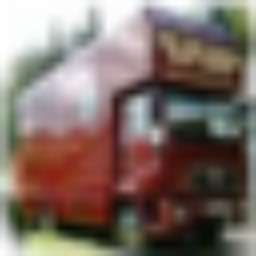

actual: truck
actual: automobile


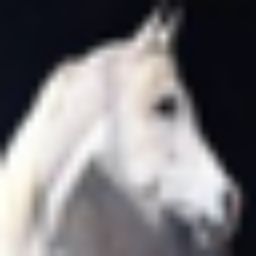

actual: horse
actual: dog


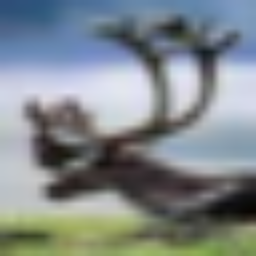

actual: deer
actual: airplane


In [219]:
fun_idx = [32, 23, 16, 49, 36, 11]
for idx in fun_idx:
    entry = missclassified[idx]
    display(entry['img'])
    print('actual:', classes[entry['label']])
    print('actual:', classes[entry['guess']])

## Representation vector

In [256]:
tsne_loader = DataLoader(test_set, batch_size=len(test_set), num_workers=2, shuffle=False)

In [ ]:
from sklearn.manifold import TSNE

def get_representation(x):
    with torch.no_grad():
        x = Resnet18.encoder.forward(x)
        x = Resnet18.decoder.avg(x)
        x = x.view(x.size(0), -1)
        return x.cpu().numpy()

for X,y in tsne_loader:
    features = get_representation(X.to(DEVICE))
    tsne = TSNE().fit_transform(features)

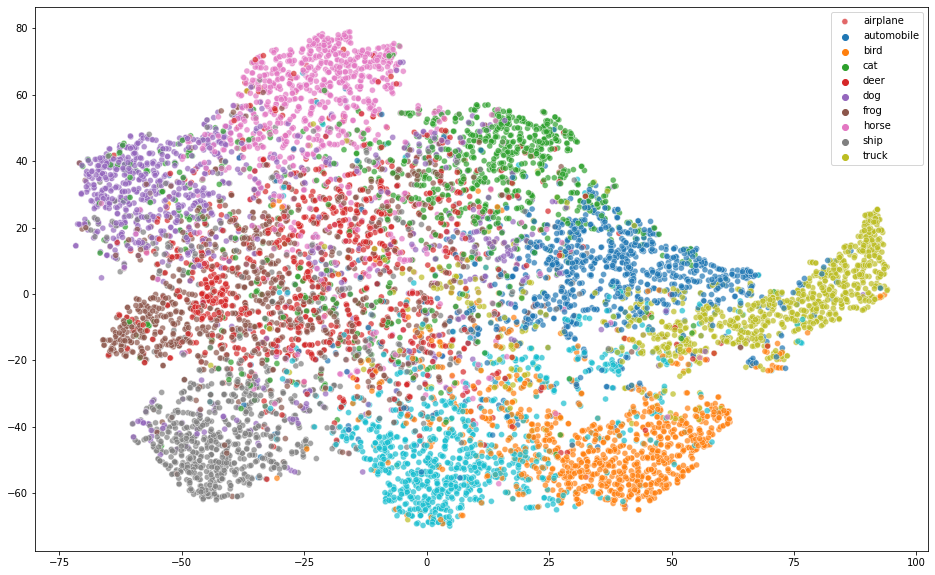

In [263]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne[:,0], y= tsne[:,1],
    hue = y.cpu().numpy(),
    palette=sns.color_palette("tab10"),
    alpha=0.7
)
plt.legend(labels=classes)
plt.show()